In [11]:
!pip install geopandas
!pip install Rtree
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon, box, mapping
import folium
import numpy as np

In [12]:
# Upload to working environment - "Ayala_FinalProjectData.zip"

In [13]:
# unzip data from zipfile
import zipfile

with zipfile.ZipFile("/content/Ayala_FinalProject1.zip", 'r') as z:
    z.extractall()

In [14]:
# read in county boundaary and CA land ownership
sandiego = gpd.read_file("/content/Ayala_FinalProject1/San Diego County Boundary (GIS)_20251130/geo_export_a1bf270d-2b70-49c4-a5e8-ac3c9abdf71d.shp")
CA_landowner = gpd.read_file("/content/Ayala_FinalProject1/California_Land_Ownership/California_Land_Ownership.shp")

In [15]:
# reproject to WGS84 because OpenStreetMaps and Folium
CA_landowner = CA_landowner.to_crs("EPSG:4326")
sandiego = sandiego.to_crs("EPSG:4326")

In [16]:
# check to make sure
print(sandiego.crs)
print(CA_landowner.crs)

EPSG:4326
EPSG:4326


In [17]:
# clip 'CA-landowner' to 'sandiego'
SD_landowner = gpd.clip(CA_landowner, sandiego)

In [18]:
# allows us to see different levels of ownership
SD_landowner.head()

,OBJECTID,OWN_LEVEL,OWN_AGENCY,OWN_GROUP,SHAPE_Leng,SHAPE_Area,geometry
35341,35342,Federal,United States Fish and Wildlife Service,US Fish and Wildlife Service,888.607240,4.083323e+04,"POLYGON ((-117.1046 32.54363, -117.1046 32.543..."
50449,50450,State,California Department of Parks and Recreation,CA Dept. of Parks and Recreation,13795.793563,4.444894e+06,"POLYGON ((-117.10587 32.54378, -117.10587 32.5..."
9800,9801,City,"San Diego, City of",Local Government,86.471371,2.593109e+02,"POLYGON ((-117.08848 32.54358, -117.08849 32.5..."
15322,15323,County,"San Diego, County of",Local Government,785.265233,2.559713e+04,"POLYGON ((-117.07163 32.5445, -117.07161 32.54..."
15320,15321,County,"San Diego, County of",Local Government,232.022358,3.044860e+03,"POLYGON ((-117.08194 32.54359, -117.08194 32.5..."


In [19]:
# this lets us see how each label gets more specific to the unique agency
print(f"OWN_LEVEL: {SD_landowner['OWN_LEVEL'].nunique()}")
print(f"OWN_GROUP: {SD_landowner['OWN_GROUP'].nunique()}")
print(f"OWN_AGENCY: {SD_landowner['OWN_AGENCY'].nunique()}")

OWN_LEVEL: 7
OWN_GROUP: 12
OWN_AGENCY: 88


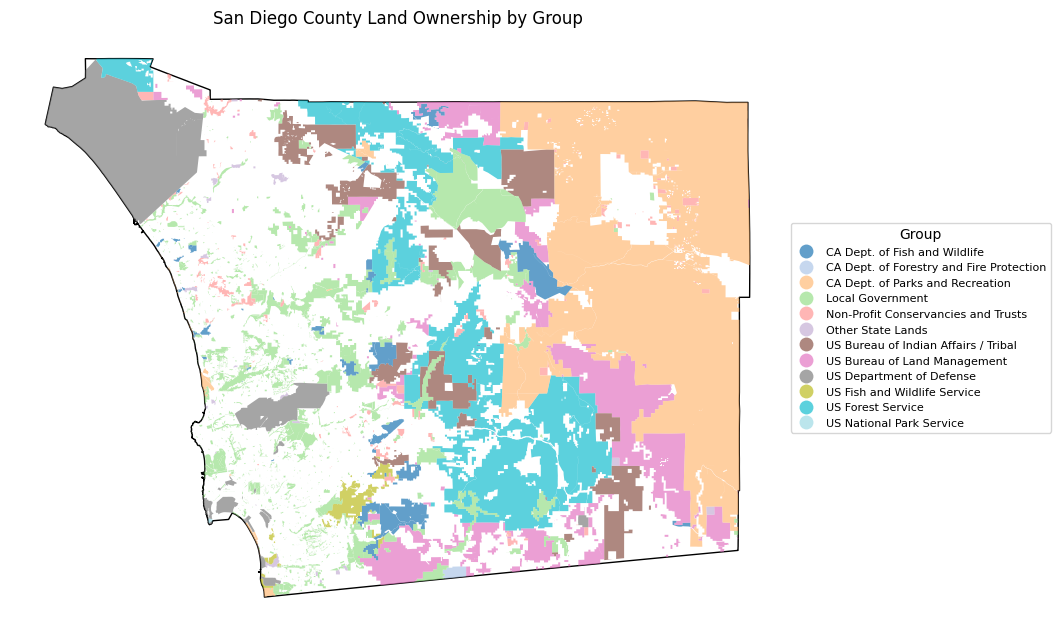

In [20]:

# visualize landowners in the county by group
fig, ax = plt.subplots(figsize=(10,15))

sandiego.plot(ax=ax, color='none', edgecolor='black')
SD_landowner.plot(column='OWN_GROUP',
                  ax=ax,
                  legend=True,
                  cmap='tab20',
                  alpha=0.7,
                  legend_kwds={
                    'loc': 'center left',
                    'bbox_to_anchor': (1, 0.5),
                    'fontsize': 8,
                    'title': 'Group'
    })

plt.title("San Diego County Land Ownership by Group")
plt.axis('off')
plt.show()

In [21]:
# make shapely geometry for next step
polygon = sandiego.geometry.iloc[0]

In [22]:
# now we have to pull trail data from OpenStreetMap

# we use osmnx for this, so import lib
!pip install osmnx
import osmnx as ox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
# this is to make the OSM query easier, we make a grid to populate each grid with trails then we merge them together
# Function to create grid of boxes
def make_grid(polygon, cell_size=0.5):
    minx, miny, maxx, maxy = polygon.bounds
    x_coords = list(np.arange(minx, maxx, cell_size))
    y_coords = list(np.arange(miny, maxy, cell_size))
    boxes = []
    for x in x_coords:
        for y in y_coords:
            b = box(x, y, x + cell_size, y + cell_size)
            if b.intersects(polygon):
                boxes.append(b.intersection(polygon))
    return boxes

# Create grid
grid = make_grid(polygon, cell_size=0.25)

# Pull trails for each tile and merge
trails_list = []
for tile in grid:
    try:
        G = ox.graph_from_polygon(
            tile,
            network_type="walk",
            custom_filter='["highway"~"path|footway|track|bridleway|steps"]'
        )
        trails_tile = ox.graph_to_gdfs(G, nodes=False, edges=True)
        trails_list.append(trails_tile)
    except:
        pass

sd_trails = pd.concat(trails_list, ignore_index=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sandiego.plot(ax=ax, color='white', edgecolor='black')
sd_trails.plot(ax=ax, color='green', linewidth=0.5)
plt.title("San Diego County Trails (OSM)")
plt.show()

In [ ]:
# saved the trails folder in case the pulling from OSM takes too long
sd_trails.to_file("SD_trails.shp")

In [ ]:
# if needed, uncomment and read in 'sd_trails.shp'
# sd_trails = gpd.read_file("/content/SD_trails.shp")

In [ ]:
# spatial join the trails with the land management
trails_by_lm = gpd.sjoin(
    sd_trails,
    SD_landowner,
    how="left",
    predicate="intersects"
)

In [ ]:
# validate it worked
print(trails_by_lm['OWN_LEVEL'].unique())

In [ ]:
# make sure projection is right with rest of data
trails_by_lm = trails_by_lm.to_crs(epsg=4326)

In [ ]:
# create foilum map with approx center of county
trail_map = folium.Map(
    location=[33.10, -116.7],
    zoom_start=12,
    tiles="CartoDB positron"
)

In [ ]:
print(trails_by_lm['OWN_GROUP'].unique())

In [ ]:
# becasue there are tiers to agencies LEVEL > GROUP > Agency, lets get the colors to depict this well
from matplotlib import colors as mcolors

# federal vs state vs local definitions
color_dict = {
    # Federal gets red shades
    'US Department of Defense': '#ff4d4d',
    'US Fish and Wildlife Service': '#ff0000',
    'US Bureau of Indian Affairs / Tribal': '#cc0000',
    'US Forest Service': '#ff6666',
    'US Bureau of Land Management': '#ff9999',
    # state gets blue shades
    'CA Dept. of Fish and Wildlife': '#3399ff',
    'CA Dept. of Parks and Recreation': '#0000cc',
    'Other State Lands': '#6666ff',
    'CA Dept. of Forestry and Fire Protection': '#0033ff',
    # local gets green
    'Local Government': '#33cc33',
    'Non-Profit Conservancies and Trusts': '#66ff66'
}

In [ ]:
# pull from agency groups in df, drop null ones
groups = trails_by_lm['OWN_GROUP'].dropna().unique()

#apply color to trails for map
trails_by_lm['color'] = trails_by_lm['OWN_GROUP'].map(color_dict).fillna('gray')

In [ ]:
# add CA landowners to map to give depth

# start with color
level_colors = {
    "Federal": "#e41a1c",   # red
    "State": "#377eb8",     # blue
    "Local": "#4daf4a",     # green
    "Other": "#FFD700"      # yellow otherwise
}

In [ ]:
folium.GeoJson(
    SD_landowner,
    name="Land Ownership",
    style_function=lambda feature: {
        "color": level_colors.get(
            feature["properties"].get("OWN_LEVEL"),
            "#FFD700"  # yellow if not
        ),
        "weight": 0,
        "fillOpacity": 0.1
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["OWN_LEVEL", "OWN_GROUP", "OWN_AGENCY"],
        aliases=["Level:", "Group:", "Agency:"]
    )
).add_to(trail_map)

In [ ]:
# add trail systems to map
trails_clean = trails_by_lm.dropna(subset=['OWN_AGENCY'])

for _, row in trails_clean.iterrows():
    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature, color=row['color']: {'color': color, 'weight': 2},
        highlight_function=lambda feature: {'weight': 5, 'color': 'yellow'},
        tooltip = folium.Tooltip(
            f"Managed by: {row['OWN_AGENCY']}\n"
            f"Level: {row['OWN_LEVEL']}\n"
            f"Group: {row['OWN_GROUP']}"
        )
    ).add_to(trail_map)

In [ ]:
trail_map

In [ ]:
trail_map.save('trail_map_map_folium.html')